# Projet d'analyse de la couverture végétale.

Le but de ce projet est d'étudier l'évolution temporelle de la couverture végétale d'une zone de votre choix.

Prérequis

* Télécharger des images FCOVER300 sur une période assez grande (plusieurs années).

* La partie "1. Récupération et nettoyage" des données" va consister à construire un fichier CSV de nom "FCOVERtable.csv" qui contiendra les moyennes et précision des mesures récupérées.

* Si vous ne pouvez pas faire ce téléchargement, j'ai placé trois extraits CSV dans des sous répertoires correspondant à trois mines issues du fichier "mines.geojson". Vous pouvez donc sauter la partie 1 mais vous n'obtiendrez pas les points correspondants.

_Version 1.0 [25/02/2023] Jérôme Lacaille_

In [33]:
import os
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

# On élargit un peu les fenêtres d'affichage de matplotlib.
plt.rcParams["figure.figsize"] = (9,6)

# On charge notre package.
import satellite as sat
from satellite import Ocli

In [34]:
%reload_ext autoreload
%autoreload 2

## 1. Analyse de l'évolution de la végétation.

La première partie du projet consiste à étudier l'évolution temporelle d'un indicateur de végétation.

Cette section donne des indications pour l'accès aux données.

### 1.1 Récupération des données optiques d'une zone d'intérêt.

On suppose que les données FCOVER ont été téléchargées dans le répertoire pointé par FCOVERDIR.

J'utilise personellement un disque externe me permettant de stocker un plus gros volume de données.

In [35]:
# On a placé les données sur un disque externe.
rawdir = "/Volumes/JLTD/Sentinel/FCOVER/"

In [36]:
oc = Ocli(rawdir,'mines.geojson')

In [37]:
oc.df

,FILE,REVISION
DATE,,
2016-01-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-01-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-01-31,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-02-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-02-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
...,...,...
2022-10-31,/Volumes/JLTD/Sentinel/FCOVER/C0166077/FCOVER3...,2
2022-11-10,/Volumes/JLTD/Sentinel/FCOVER/C0166077/FCOVER3...,2
2022-11-20,/Volumes/JLTD/Sentinel/FCOVER/C0166077/FCOVER3...,2


### 1.2 Tables CSV contenant des données prétraitées.

Pour vous faciliter le travail, j'ai préparré en avance quelques données moyennes dans des fichiers CSV.

In [38]:
# La liste des zones que j'ai préparées.
oc.names

['Barro Alto - Nickel (Brésil)',
 'Vale Moatize - Charbon (Mozambique)',
 'South Walker Creek - Coal (Australie)']

In [39]:
# Accès à un fichier FCOVERtable.csv.
zonedir = os.path.realpath(
    os.path.join(
    os.path.dirname(sat.EARTHDIR),'..','Barro-Alto'))
print(zonedir)
df = pd.read_csv(os.path.join(zonedir,'FCOVERtable.csv'))
df.set_index('DATE', drop=True, inplace=True)
df.head()

/Users/holie/wrk0/satellite/data/zones/Barro-Alto


,FILE,REVISION,FCOVER,RMSE,PR
DATE,,,,,
2016-01-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.808591,0.124193,0.821652
2016-01-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.799199,0.032586,1.000000
2016-01-31,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.806481,0.033995,1.000000
2016-02-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.811652,0.034934,0.998123
2016-02-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.812406,0.036070,0.999374


Pour les données RVI (Radar Vegetation Index) calculées à partir de mesures radar des satellites Seninel 1, j'ai aussi préparé un jeu de données moyenné dans un fichier CSV.

In [40]:
# Lecture du fichier CSV de l'indicateur RVI.
df = pd.read_csv(os.path.join(zonedir,'RVItable.csv'))
df.set_index('DATE', drop=True, inplace=True)
df.head()

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,DX,DY,ZIPFILE,RVIC
DATE,,,,,,,,,,,
2019-04-08,2.022880,0.014757,45.177209,39.718881,-1,0.348049,-1.002555,11381.5,-1208.0,S1A_IW_GRDH_1SDV_20190408T084503_20190408T0845...,2.026044
2019-04-13,2.030516,0.020464,32.315486,28.789817,-1,0.059303,0.987514,-10136.0,-3043.0,S1A_IW_GRDH_1SDV_20190413T085312_20190413T0853...,2.026746
2019-04-20,2.022383,0.014615,45.171332,39.713658,-1,0.347935,-1.002663,11390.0,-1208.0,S1A_IW_GRDH_1SDV_20190420T084504_20190420T0845...,2.026234
2019-04-25,2.028855,0.018965,32.306826,28.782296,-1,0.059273,0.988726,-10146.0,-3043.0,S1A_IW_GRDH_1SDV_20190425T085313_20190425T0853...,2.026005
2019-05-02,2.021148,0.013618,45.172762,39.714986,-1,0.347987,-1.002477,11380.5,-1208.0,S1A_IW_GRDH_1SDV_20190502T084504_20190502T0845...,2.025450


## 2. Accès aux données radar.

Cette seconde section donne des éléments pour vous aider à accéder à des données radar.

In [41]:
# Je choisis une zone exemple.
zone = oc[0]
zone

{'name': 'Barro Alto - Nickel (Brésil)',
 'bbox': [-15.120681846262826,
  -49.064565561195195,
  -15.03010101576109,
  -48.93317158095951]}

### 2.1 Récupération des dossiers .SAFE.

Pour accéder aux données radar il faut passer par SentinelHub. L'outil enligne (ainsi que la version programmable) utilise une requête particulière. Pour vous aider j'ai rajouter la fonction qui construit la chaine requête.

> [SentinelHub](https://scihub.copernicus.eu/dhus/#/home)

_Faire attention aux positions des espaces et des virgules._

L'interface nécessite de s'identifier (c'est gratuit), on peut utiliser les mêmes identifiants que sur GLS.

In [42]:
# Le module radar.py va contenir quelques fonctions d'aide.
sat.radar.rviquery(zone)

'(footprint:"Contains(POLYGON((-49.065 -15.121,-48.933 -15.121,-48.933 -15.030,-49.065 -15.030,-49.065 -15.121)))") AND  ((platformname:Sentinel-1 AND producttype:GRD))'

Vous pouvez copier le résultat de cette requête dans SentinelHub pour regarder les produits disponibles.

Chaque produit est un fichier archive .zip. Une fois décompressé des données sont stockées dans un dossier .SAFE.

_(Vous pouvez utiliser le package zipfile si vous programmez vos récupérations.)_

In [43]:
# Liste des répertoires .SAFE que vous avez téléchargés.
listsafe = [froot for froot,_,_ in os.walk(zonedir)
            if froot.endswith('.SAFE')] 
print(listsafe)
safedir0 = listsafe[0]

['/Users/holie/wrk0/satellite/data/zones/Barro-Alto/GRD/SAFE/S1A_IW_GRDH_1SDV_20221217T085338_20221217T085403_046369_058DE9_861C.SAFE']


### 2.2 Lecture des métadonnées dans des fichiers XML.

Les dossiers .SAFE contiennet un certan nombre de fichiers XML pour le stockage de métadonnées et d'autres informations concernant l'acquisition.

Deux fichiers XML conteiennet les métadonnées.
À chaque fichier .xml est associé un fichier image .tiff.
Les étapes suivantes vons montrer comment extraire une zone particulière (notre geozone) de l'image acquise.

Je ne traiterai pas les zones qui seraient à cheval sur plusieurs acquisitions. Pour cela il faudra faire des développements plus complexes.

In [44]:
# Récupération du premier fichier de calibration.
xmlfiles = [fname 
            for fname in os.listdir(os.path.join(safedir0,'annotation'))
            if fname.endswith('.xml')]
xmlfile0 = os.path.join(safedir0,'annotation',xmlfiles[0])
xmlfile0

'/Users/holie/wrk0/satellite/data/zones/Barro-Alto/GRD/SAFE/S1A_IW_GRDH_1SDV_20221217T085338_20221217T085403_046369_058DE9_861C.SAFE/annotation/s1a-iw-grd-vv-20221217t085338-20221217t085403-046369-058de9-001.xml'

In [45]:
# Import des outils de gestion des XML.
import datetime as dt
from xml.etree import ElementTree

In [46]:
# Chargement des éléments d'intérêt.
root = ElementTree.parse(xmlfile0)

Un fichier XML se lit progressivement en decendant le long d'une arborescence. Pour se faciliter le travail on écrit une petite fonction qui récupère la valeur par défaut d'une clé. Dans les fichiers de métadonnées du répertoire .SAFE la seule propriété associée à une clé sera sa valeur représentée par le champ `text`.

In [47]:
def getxmltext(root,name):
    for e in root.iter(name):
        return e.text # On s'arrête dès qu'on a trouvé.

Je crée un dictionnaire `desc` contenant une série de métadonnées intéressantes. Vous pouvez aller en chercher d'autres.

In [48]:
# Une liste de métadonnées générales.
desc = dict(
    polarisation = getxmltext(root,'polarisation'),
    date = dt.datetime.fromisoformat(getxmltext(root,'startTime')),
    direction = getxmltext(root,'pass'),
    heigth = int(getxmltext(root,'numberOfLines')),
    width = int(getxmltext(root,'numberOfSamples')))
desc

{'polarisation': 'VV',
 'date': datetime.datetime(2022, 12, 17, 8, 53, 38, 908631),
 'direction': 'Descending',
 'heigth': 16834,
 'width': 26028}

Je crée ensuite un tableau de correspondance entre les axes cartésiens xy de l'image et les positions géographiques (latitude, lognitude). Ce tableau est clairement sous-échantillonné, mais vu la précision de l'acquisition (10x10 m par pixel) une interpolation linéaire suffira.

In [49]:
# Une description du contenu.
M = [(int(e.find('line').text),int(e.find('pixel').text),
        float(e.find('latitude').text), float(e.find('longitude').text),
        float(e.find('incidenceAngle').text),
        float(e.find('elevationAngle').text) 
        )
        for e in root.iter('geolocationGridPoint')]
code = pd.DataFrame(M,columns=['line','pixel','lat','lon',
                                'incidence','elevation'])
code

,line,pixel,lat,lon,incidence,elevation
0,0,0,-14.689039,-48.631225,30.381908,27.108198
1,0,1302,-14.663079,-48.746166,31.269022,27.881119
2,0,2604,-14.637377,-48.859700,32.127769,28.627043
3,0,3906,-14.610765,-48.976950,33.010418,29.393150
4,0,5208,-14.583846,-49.095250,33.889872,30.154990
...,...,...,...,...,...,...
205,16833,20832,-15.760499,-50.871394,43.220041,38.088684
206,16833,22134,-15.732535,-50.989795,43.922290,38.673580
207,16833,23436,-15.704438,-51.108457,44.615353,39.248997
208,16833,24738,-15.676445,-51.226384,45.289029,39.805725


Là encore, pour vous faciliter le travail, j'ai créé cette fonction `getllmask()` dans le module radar.py pour préparer l'extraction d'une sosu-image rectangulaire (en xy) contenant la zone géographique d'intérêt.

In [50]:
mask = sat.radar.getllmask(zone,desc,code)
mask

{'bbox': (2130, 4320, 3780, 5640),
 'incidence': 32.374387212965644,
 'elevation': 28.841538996243983,
 'dvec': (0.09684454154431776, 0.9881063421634195),
 'dxy': (-10059.0, -3437.0),
 'lat': array([[-15.03277345, -15.0327532 , -15.03273294, ..., -14.99937033,
         -14.99935012, -14.99932991],
        [-15.03286337, -15.03284311, -15.03282285, ..., -14.9994599 ,
         -14.99943969, -14.99941948],
        [-15.03295328, -15.03293302, -15.03291277, ..., -14.99954947,
         -14.99952926, -14.99950905],
        ...,
        [-15.15121666, -15.15119626, -15.15117586, ..., -15.11733009,
         -15.11730988, -15.11728967],
        [-15.15130667, -15.15128627, -15.15126587, ..., -15.11741966,
         -15.11739945, -15.11737924],
        [-15.15139667, -15.15137627, -15.15135587, ..., -15.11750923,
         -15.11748902, -15.11746881]]),
 'lon': array([[-48.91226553, -48.91235492, -48.91244431, ..., -49.05941427,
         -49.05950325, -49.05959222],
        [-48.91228487, -48.9123

### 2.3 Extraction d'une image.

Pour cahque fichier XML correspondant à une polarisation, il existe une image interferometrique de retour.

Cette section décrit comment accéder aux images. On récupère la première image, bien entendu, pour construire l'indicateur RVI il faut combiner les deux polarisations.

In [51]:
# Le fichier image .tiff correspondant aux métadonnées .xml.
tiffile0 = os.path.join(safedir0, 'measurement', xmlfiles[0][:-4]+'.tiff')
tiffile0

'/Users/holie/wrk0/satellite/data/zones/Barro-Alto/GRD/SAFE/S1A_IW_GRDH_1SDV_20221217T085338_20221217T085403_046369_058DE9_861C.SAFE/measurement/s1a-iw-grd-vv-20221217t085338-20221217t085403-046369-058de9-001.tiff'

Pour ouvrir les fichiers .tiff j'utilise GDAL. Il existe plusieurs méthodes pour récupéer cette librairie.

> [Librairie GDAL](https://pypi.org/project/GDAL/)

Sur MacOS j'ai eu plus de facilité à utiliser osgeo qui est intégrée dans anaconda (sous la dénomination gdal ?) mais ce n'est pas une obligation.

> [Librairie OSGEO](https://pypi.org/project/osgeo/)

In [52]:
# La bibliothèque gdal sert à la gestion des images satellites tiff.
from osgeo import gdal

In [53]:
# Ouverture et récupération de la bande
ds = gdal.Open(tiffile0,gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
# On extrait la partie de l'image qui nous intéresse.
minx,miny,maxx,maxy = mask['bbox'] 
img = band.ReadAsArray(minx,miny,maxx-minx,maxy-miny)
img

array([[161, 114, 180, ..., 326, 253, 193],
       [172, 145, 204, ..., 275, 258, 246],
       [142, 156, 187, ..., 267, 284, 270],
       ...,
       [203, 288, 313, ..., 236, 298, 328],
       [175, 232, 247, ..., 233, 364, 497],
       [191, 197, 199, ..., 241, 479, 645]], dtype=uint16)

`imgnorm`: une dernière petite fonction de normalisation intégrée au module radar.py.

Vous verrez que les images possèdent parfois des valeurs extrêmes qu'il faut supprimer si on souhaite améliorer le contraste. Cette fonction renormalise l'image pour qu'elle puisse être affichée avec `plt.imshow()`, mais elle extrait d'abord les données des quantiles extrêmes. 

Pour l'affichage pensez à retourner l'axe des ordonnées pour afficher des coordonnées cartésiennes.

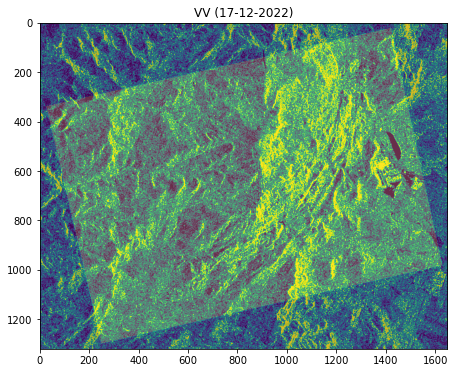

In [66]:
fimg = sat.radar.imgnorm(img,.1)
f = plt.imshow(fimg[:,::-1])
ax = f.axes
        
belong = mask['belong']
ax.imshow(belong[:,::-1], alpha=0.2)
ax.set_title(desc['polarisation'] + 
             ' (' + dt.datetime.strftime(desc['date'],"%d-%m-%Y") +')',
             fontsize=12);

_(Attention pour le calcul de l'indicateur RVI n'oubliez pas de repasser en linéaire. Les données stockées sont logarithmiques.)_

_Fini._